# AI Algorithms Project - Option B
Gabriel SULTAN - Lalith Adithya CHANUMOLU - Jules WEJROCH - Alida Dovila ZOGO KANDA LONGMIS - DIA 6

#  Cost and Performance Optimization for Application Deployment and Scaling

**Problem Context and Motivation :** 
#
Modern Machine Learning models, especially in fields like Deep Learning, are becoming increasingly
large and complex. Training these models on a single machine can take weeks or even months, creating a
significant bottleneck in the AI development cycle. To accelerate this process, companies use distributed
training, where the computational workload is spread across multiple machines in a cloud environment.
This approach can drastically reduce training time, but it introduces a major challenge: cost and
resource management.


The objective is to configure the training cluster to minimize the total hourly infrastructure cost while ensuring the training process is stable and efficient

# 1. Problem Formulation
(AI have been used for the formatting of mathematical formulas in this part)

## 2.1. Sets and Indices

- **I** = {1, 2, 3, 4} : set of application components
- **J** : set of available virtual machine (VM) types
- **T** : set of time periods (if the problem is dynamic)

## 2.2. Parameters

For each component **i ∈ I** :
- **μᵢ** : service rate of component i (requests/second per replica)
- **λᵢ** : maximum arrival rate for component i (requests/second)
- **rᵢᵐⁱⁿ** : minimum number of replicas required for component i

For each VM type **j ∈ J** :
- **CPUⱼ** : number of CPUs available on a VM of type j
- **RAMⱼ** : amount of RAM available on a VM of type j (in GiB)
- **Costⱼ** : hourly cost of a VM of type j
- **Quantityⱼ** : maximum number of VMs of type j available
- **Rⱼ** : maximum number of replicas that a VM of type j can host
  - Rⱼ = min(CPUⱼ, ⌊RAMⱼ / 0.25⌋)

Global parameters :
- **CPU_req** = 1 : number of CPUs required per replica
- **RAM_req** = 0.25 : amount of RAM required per replica (in GiB)

## 2.3. Decision Variables

- **rᵢ** ∈ ℤ⁺ : number of replicas allocated to component i (i ∈ I)
- **xⱼ** ∈ ℤ⁺ : number of VMs of type j to deploy (j ∈ J)
- **yᵢⱼ** ∈ ℤ⁺ : number of replicas of component i placed on VMs of type j (optional, for explicit placement modeling)

## 2.4. Objective Function

Minimize the total hourly infrastructure cost :

$$\min Z = \sum_{j \in J} x_j \cdot \text{Cost}_j$$

## 2.5. Constraints

### 2.5.1. Service Stability

For each component i, the number of replicas must be sufficient to handle the maximum load :

$$r_i \cdot \mu_i \geq \lambda_i, \quad \forall i \in I$$

or equivalently :

$$r_i \geq \left\lceil \frac{\lambda_i}{\mu_i} \right\rceil = r_i^{min}, \quad \forall i \in I$$

### 2.5.2. CPU Resource Sufficiency

The total CPU capacity of the cluster must be at least equal to the total demand :

$$\sum_{j \in J} x_j \cdot \text{CPU}_j \geq \sum_{i \in I} r_i \cdot \text{CPU}_{req}$$

$$\sum_{j \in J} x_j \cdot \text{CPU}_j \geq \sum_{i \in I} r_i$$

### 2.5.3. RAM Resource Sufficiency

The total RAM capacity of the cluster must be at least equal to the total demand :

$$\sum_{j \in J} x_j \cdot \text{RAM}_j \geq \sum_{i \in I} r_i \cdot \text{RAM}_{req}$$

$$\sum_{j \in J} x_j \cdot \text{RAM}_j \geq 0.25 \cdot \sum_{i \in I} r_i$$

### 2.5.4. VM Availability

The number of VMs of each type cannot exceed the available quantity :

$$x_j \leq \text{Quantity}_j, \quad \forall j \in J$$

### 2.5.5. Valid Replica Placement

The total number of placed replicas cannot exceed the total capacity of the cluster :

$$\sum_{i \in I} r_i \leq \sum_{j \in J} x_j \cdot R_j$$

This constraint ensures that each VM can host at most Rⱼ replicas.

### 2.5.6. Domain Constraints

$$r_i \in \mathbb{Z}^+, \quad \forall i \in I$$
$$x_j \in \mathbb{Z}^+, \quad \forall j \in J$$

## 2.6. Model Summary

**Problem Type** : Integer Linear Program (ILP)

**Objective** : Cost minimization

**Complexity** : NP-hard (combinatorial optimization with integer variables)

**Possible Solution Methods** :
- Branch and Bound
- Heuristic algorithms (greedy, simulated annealing, etc.)
- ILP solvers (CPLEX, Gurobi, OR-Tools)


# 2. Data Loading and Preprocessing


In [73]:
#import necessary librairies for the project
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import time

In [74]:
#load as dataframes for easier manipulation
df_vm =pd.read_csv('VM_Catalogue.csv',sep=';')
df_workload = pd.read_csv('Workload.csv',sep=';')

In [75]:
#clean the dataframe
df_vm_clean= df_vm.copy()

df_vm_clean.columns = df_vm_clean.iloc[0] #set the first row as the header
df_vm_clean = df_vm_clean[1:].reset_index(drop=True) #drop the first row and reset the index

#convert to numeric values
df_vm_clean['CPU']=pd.to_numeric(df_vm_clean['CPU'])
df_vm_clean['RAM']= pd.to_numeric(df_vm_clean['RAM'])
df_vm_clean['Cost'] =pd.to_numeric(df_vm_clean['Cost'])
df_vm_clean['Quantity'] = pd.to_numeric(df_vm_clean['Quantity'])


In [76]:
#here we augment the dataframe with important columns we'll need later
#compute max replicas per VM
df_vm_clean['max_replicas'] = df_vm_clean.apply(
    lambda row: min(int(row['CPU'] // 1), int(row['RAM'] // 0.25)),
    axis=1)

# Compute cost per replicas
df_vm_clean['cost_per_replica'] = df_vm_clean['Cost'] / df_vm_clean['max_replicas']

print(df_vm_clean[['Type', 'CPU', 'RAM', 'Cost', 'Quantity', 'max_replicas', 'cost_per_replica']])


0  Type  CPU      RAM     Cost  Quantity  max_replicas  cost_per_replica
0   T00    1     3.75   0.1914        10             1          0.191400
1   T01    2     1.80   0.2104        10             2          0.105200
2   T02    2     7.50   0.2684        10             2          0.134200
3   T03    2    13.00   0.2944        10             2          0.147200
4   T04    4     3.60   0.3064        10             4          0.076600
5   T05    4    15.00   0.4224        10             4          0.105600
6   T06    4    26.00   0.4744        10             4          0.118600
7   T07    8     7.20   0.4984        10             8          0.062300
8   T08    8    30.00   0.7304        10             8          0.091300
9   T09    8    52.00   0.8344        10             8          0.104300
10  T10   16    14.40   0.8824        10            16          0.055150
11  T11   16    60.00   1.3464        10            16          0.084150
12  T12   16   104.00   1.5544        10           

In [77]:
#service rates per component (μ) as given in the project statement
mu ={1: 1416, 2:696, 3:1005,4:1259}

In [78]:

# Peak workload (λ_max)
peak_workload = df_workload['input_rate'].max()
print(f"peak workload : {peak_workload}")

#Find the minimum replicas for each component (r_min)
r_min={}
for comp_id,mu_c in mu.items():
    r_min[comp_id] =int(np.ceil(peak_workload /mu_c)) #compute it

for comp_id in sorted(r_min.keys()):
    print(f"Component {comp_id}: r_min = {r_min[comp_id]} (μ={mu[comp_id]})")#display it



#total minimum replicas needed
total_min_replicas = sum(r_min.values())
print(f"\nTotal minimum replicas needed: {total_min_replicas}")


peak workload : 5751
Component 1: r_min = 5 (μ=1416)
Component 2: r_min = 9 (μ=696)
Component 3: r_min = 6 (μ=1005)
Component 4: r_min = 5 (μ=1259)

Total minimum replicas needed: 25


# 3. AI-Based Solution Approaches

We will implement three heuristic algorithms to solve the optimization problem:

1. **Greedy Algorithm** - Cost per replica based selection
2. **Hill Climbing** - Local search optimization with restart
3. **Simulated Annealing** - Metaheuristic with temperature-based acceptance


In [88]:
#Base class for VM optimization algorithms that will help us implement our algorithms
class VMOptimizer:    


    #initialize the class and take all the parameters needed
    def __init__(self, vm_df, r_min_dict, mu_dict): 
        
        self.vm_df = vm_df.copy()
        self.r_min = r_min_dict
        self.mu = mu_dict
        self.components = sorted(r_min_dict.keys())
        self.vm_types = list(range(len(vm_df)))
        
        #get all the VM's parameters
        self.vm_cpu = vm_df['CPU'].values
        self.vm_ram = vm_df['RAM'].values
        self.vm_cost = vm_df['Cost'].values
        self.vm_quantity = vm_df['Quantity'].values
        self.vm_max_replicas = vm_df['max_replicas'].values
        
    def calculate_cost(self, x):
        #return the total cost for VM allocation x
        return np.sum(x*self.vm_cost) #basically sum the cost of all the VMs in x
    
    def check_constraints(self, r, x):
        #Check if solution (r, x) satisfies all constraints


        #stability: ri >= r_min[i]
        for i, comp_id in enumerate(self.components):
            if r[comp_id] < self.r_min[comp_id]:
                return False
        
        #CPU sufficiency
        total_cpu= np.sum(x * self.vm_cpu)
        total_replicas = sum(r.values())
        if total_cpu < total_replicas: #here the contraint
            return False
        
        # RAM sufficiency
        total_ram =np.sum(x * self.vm_ram)
        if total_ram < 0.25 * total_replicas:
            return False
        
        #VM availability, quantity check
        for j in range(len(x)):
            if x[j] > self.vm_quantity[j]:
                return False
        
        #valid placement
        total_capacity=np.sum(x*self.vm_max_replicas)
        if total_replicas> total_capacity :
            return False
        
        
        return True,"all the constraints are satisfied !"
    
    def get_resource_utilization(self, r, x):
        #extra metrics on the resources used 

        total_replicas=sum(r.values())
        total_cpu=np.sum(x *self.vm_cpu)
        total_ram= np.sum(x*self.vm_ram)
        total_capacity=np.sum(x*self.vm_max_replicas)


        
        return {
            'cpu utilization': total_replicas /total_cpu if total_cpu > 0 else 0,
            'ram utilization': (0.25*total_replicas) / total_ram if total_ram>0 else 0,
            'capacity utilization': total_replicas/total_capacity if total_capacity>0 else 0}


In [ ]:
#Greedy algorithm: selecting VMs based on cost per replica efficiency
class GreedyOptimizer(VMOptimizer):
    
    def solve(self): #here is the greedy approach
        
        #sorting VM by cost per replica 
        sorted_vms=self.vm_df.sort_values('cost_per_replica').reset_index(drop= True)
        

        #initialize
        x =np.zeros(len(self.vm_df), dtype=int)#initializing the vector of VMs
        r = {comp_id: self.r_min[comp_id] for comp_id in self.components}#initializing the vector of replicas
        total_replicas = sum(r.values())#total replicas needed
        


        #track allocated resources
        allocated_cpu=0
        allocated_ram=0
        allocated_capacity= 0
        
        # greedily add VMs until constraints are satisfied
        for idx, row in sorted_vms.iterrows(): #iterating over the sorted VMs
            vm_idx = self.vm_df.index[self.vm_df['Type'] == row['Type']].tolist()[0] #getting the index of the VM
            max_to_add = int(row['Quantity']) #getting the max quantity of the VM
            
            while (allocated_cpu < total_replicas or 
                   allocated_ram < 0.25 * total_replicas or
                   allocated_capacity < total_replicas) and x[vm_idx] < max_to_add: 
                   #while the constraints are not satisfied and the VM is not at its max
                x[vm_idx] += 1
                allocated_cpu += row['CPU']
                allocated_ram += row['RAM']
                allocated_capacity += row['max_replicas']
        
        #verify and return solution
        is_valid, message = self.check_constraints(r, x)
        cost = self.calculate_cost(x)
        
        
        return {
            'r': r,
            'x': x,
            'cost': cost,
            'valid': is_valid,
            'message': message,
            'utilization':self.get_resource_utilization(r, x)}

In [ ]:
#Hill climbing algorithm with restart for VM optimization
class HillClimbingOptimizer(VMOptimizer):
    
    #initialize the class
    def __init__(self, vm_df,r_min_dict,mu_dict, max_iterations = 1000, 
                 max_stagnation= 50,num_restarts=5, stochastic_prob=0.1): #parameters for hill climbing algo
    
        super().__init__(vm_df, r_min_dict, mu_dict)
        #parameters for hill climbing algo
        self.max_iterations=max_iterations 
        self.max_stagnation= max_stagnation
        self.num_restarts =num_restarts
        self.stochastic_prob = stochastic_prob
        
        #sort VM by cost per replica for smart neighbor generation
        self.sorted_vm_indices=vm_df.sort_values('cost_per_replica').index.tolist()
    
    def repair_solution(self,x,r):
        #this function repairs an invalid solution to make it feasible


        x_rep=x.copy()
        r_rep={k: v for k, v in r.items()}
        
        # make sure minimum replicas 
        for comp_id in self.components:
            r_rep[comp_id] =max(r_rep[comp_id], self.r_min[comp_id]) 
        
        total_replicas=sum(r_rep.values()) #total replicas needed
        
        #compute current resources
        total_cpu = np.sum(x_rep * self.vm_cpu)
        total_ram = np.sum(x_rep * self.vm_ram)
        total_capacity = np.sum(x_rep * self.vm_max_replicas)
        
        #Add VMs if resources are insufficient (prefer cheaper VMs)
        while (total_cpu<total_replicas or total_ram <  0.25 * total_replicas or total_capacity < total_replicas): 
            #while the constraints are not satisfied
            added =False

            for vm_idx in self.sorted_vm_indices : #iterating over the sorted VMs

                if x_rep[vm_idx] < self.vm_quantity[vm_idx]: #quantity check
                    x_rep[vm_idx] += 1 #adding a VM
                    total_cpu += self.vm_cpu[vm_idx]
                    total_ram += self.vm_ram[vm_idx]
                    total_capacity += self.vm_max_replicas[vm_idx]
                    added =True
                    break

            if not added:
                break
        
        #remove excess VMs (optimize cost)
        for vm_idx in reversed(self.sorted_vm_indices): #iterating over the sorted VMs in reverse
            if x_rep[vm_idx] > 0: 
                x_test = x_rep.copy()
                x_test[vm_idx] -=1

                total_cpu_test = np.sum(x_test * self.vm_cpu)
                total_ram_test = np.sum(x_test * self.vm_ram)
                total_capacity_test = np.sum(x_test * self.vm_max_replicas)
                

                if (total_cpu_test >= total_replicas and total_ram_test >= 0.25 * total_replicas and total_capacity_test >= total_replicas) :
                    #if the constraints are satisfied
                    x_rep = x_test
                    total_cpu =total_cpu_test
                    total_ram=total_ram_test
                    total_capacity=total_capacity_test
        
        return x_rep, r_rep #return the repaired solution
    
    def generate_neighbors(self, x, r): 
        #now we can generate the neighbors

        neighbors=[]
        
        #add VM (cheaper ones)
        for vm_idx in self.sorted_vm_indices[:10] :  
            #we try the top 10 cheapest
            if x[vm_idx] <self.vm_quantity[vm_idx]: #if the VM is not at its max
                x_new =x.copy()
                x_new[vm_idx]+= 1
                x_new, r_new =self.repair_solution(x_new, r)

                if self.check_constraints(r_new, x_new)[0]: #check constraints
                    neighbors.append((x_new, r_new)) #add the neighbor to the list
        
        #remove VM (expensive ones)
        used_vms= [i for i in range(len(x)) if x[i] > 0] #getting the indices of the VMs that are used
        used_vms_sorted = sorted(used_vms, key=lambda i: self.vm_cost[i], reverse=True)#sorting them by cost
        for vm_idx in used_vms_sorted[:10]:  #we try the top 10 most expensive
            x_new = x.copy()
            x_new[vm_idx] -=1
            x_new, r_new=self.repair_solution(x_new, r)#call the repair function

            if self.check_constraints(r_new, x_new)[0]: 
                neighbors.append((x_new, r_new)) 
        
        #Swap VM by removing expensive and adding cheaper
        for vm_remove in used_vms_sorted[:5]: #iterating over the top 5 most expensive VMs
            for vm_add in self.sorted_vm_indices[:5]: #iterating over the top 5 cheapest VMs
                if x[vm_remove] > 0 and x[vm_add] < self.vm_quantity[vm_add]: 
                    x_new = x.copy()
                    x_new[vm_remove] -=1
                    x_new[vm_add]+=1
                    x_new, r_new =self.repair_solution(x_new, r)

                    if self.check_constraints(r_new, x_new)[0]:
                        neighbors.append((x_new, r_new))
        
        #change replica count
        for comp_id in self.components:
            #increase
            r_new = {k: v for k, v in r.items()}#copying the replicas
            r_new[comp_id] += 1#increasing the replica count
            x_new, r_new = self.repair_solution(x, r_new)

            if self.check_constraints(r_new, x_new)[0]:
                neighbors.append((x_new, r_new))
            
            #decrease
            if r[comp_id] > self.r_min[comp_id]: #if above minimum
                r_new = {k: v for k, v in r.items()}
                r_new[comp_id] -= 1
                x_new, r_new = self.repair_solution(x, r_new)

                if self.check_constraints(r_new, x_new)[0]:
                    neighbors.append((x_new, r_new))
        
        return neighbors 
    
    
    def create_initial_solution(self, use_greedy=False): 
        #now we can create the initial solution
       
        if use_greedy: #we'll use the greedy for the first restart as it is already a good solution
            greedy=GreedyOptimizer(self.vm_df,self.r_min,self.mu)
            solution =greedy.solve()
            return solution['x'].copy(), solution['r'].copy() #return initial solution
            
        #now we want random solutions for following restarts to explore different parts of the search space
        r ={comp_id: self.r_min[comp_id] for comp_id in self.components} #initializing the replicas
        x = np.zeros(len(self.vm_df), dtype=int) #initializing the VMs
        total_replicas = sum(r.values()) #total replicas needed
        
        # Add VMs randomly until constraints are satisfied
        vm_weights=[1.0 / (self.vm_df.iloc[i]['cost_per_replica'] + 0.01) for i in range(len(self.vm_df))] 
        vm_weights = np.array(vm_weights)#converting to array
        vm_weights = vm_weights / vm_weights.sum() #normalizing
        
        while True:

            vm_idx =np.random.choice(len(x),p=vm_weights)#choosing a VM randomly

            if x[vm_idx]<self.vm_quantity[vm_idx]: #if the VM is not at its max
                x[vm_idx]+= 1 #adding a VM

                total_cpu=np.sum(x * self.vm_cpu) #updating the total CPU
                total_ram=np.sum(x * self.vm_ram) #updating the total RAM
                total_capacity=np.sum(x * self.vm_max_replicas)
                
                if (total_cpu >= total_replicas and total_ram >= 0.25 * total_replicas and total_capacity >= total_replicas):
                    break #make sureconstraints are satisfied
        
        x, r =self.repair_solution(x, r) #repair the solution
        return x,r
    
    def hill_climb(self, x_start, r_start, verbose=False):
        #now we can perform the hill climbing
        x_current =x_start.copy()#copying the current solution
        r_current = {k: v for k, v in r_start.items()}#copying the replicas
        cost_current = self.calculate_cost(x_current)# cost of the current solution
        
        best_x = x_current.copy()#copying the best solution
        best_r = {k: v for k, v in r_current.items()}#copying the best replicas
        best_cost = cost_current#copying the best cost
        

        stagnation= 0#initialising the stagnation
        iteration= 0#initializing the iteration
        history=[]#initializing the history
        

        while iteration < self.max_iterations and stagnation < self.max_stagnation:
            neighbors = self.generate_neighbors(x_current, r_current)#call generate the neighbors
            
            
            #evaluate all neighbors
            neighbor_costs =[self.calculate_cost(x) for x,r in neighbors]
            best_neighbor_idx=np.argmin(neighbor_costs)#getting the index of the best neighbor
            best_neighbor_cost = neighbor_costs[best_neighbor_idx]#his cost
            
            #Accept if better or with small probability if worse (stochastic)
            if best_neighbor_cost<cost_current:
                x_current,r_current = neighbors[best_neighbor_idx]
                cost_current = best_neighbor_cost
                stagnation=0
                
                if cost_current<best_cost:
                    best_x=x_current.copy()
                    best_r = {k: v for k, v in r_current.items()}
                    best_cost = cost_current
            elif random.random() < self.stochastic_prob:
                #stochastic acceptance of worse solution
                x_current,r_current =neighbors[best_neighbor_idx] #updating the current solution
                cost_current = best_neighbor_cost#updating the cost
                stagnation += 1
            else:
                stagnation += 1
            
            iteration +=1
            history.append({'iteration': iteration, 'cost': best_cost})#appending the history
        
        return best_x,best_r,best_cost,history #return the best solution
    
    def solve(self, verbose=False):
        #now we can solve the problem with multiple restarts
        
        best_x,best_r  = None
        best_cost =np.inf
        all_history =[]
        
        for restart in range(self.num_restarts):
            
            #greedy for first restart, random for others
            use_greedy =(restart == 0)
            x_start,r_start=self.create_initial_solution(use_greedy=use_greedy)
            
            x_sol, r_sol, cost_sol, history =self.hill_climb(x_start, r_start, verbose=False) #call the hill climbing
            
            #update history with restart info
            for h in history:
                h['restart'] = restart+ 1
                h['iteration']=h['iteration'] + restart*self.max_iterations

            all_history.extend(history)
            


            if cost_sol<best_cost :
                best_x =x_sol
                best_r= r_sol
                best_cost=cost_sol
            
            if verbose: #verbose to track progress 
                print(f"Best cost: ${best_cost:.4f}")
        
        is_valid, message = self.check_constraints(best_r, best_x)
        
        return {
            'r': best_r,
            'x': best_x,
            'cost': best_cost,
            'valid': is_valid,
            'message': message,
            'utilization': self.get_resource_utilization(best_r, best_x),
            'history': all_history} #final return



In [ ]:
#Simulated anneanling algorithm with cooling rate
class SimulatedAnnealingOptimizer(VMOptimizer):   

#(some annotations are missing as they are the same as the hill climbing ones)
#(also some of the code here have been directly copied/pasted from the hill climbing code)

    #initialize the class
    def __init__(self, vm_df, r_min_dict, mu_dict, initial_temp= 1000, 
                 cooling_rate= 0.95,min_temp = 0.1, iterations_per_temp=50):
        
        super().__init__(vm_df, r_min_dict, mu_dict)
        #parameters for simulated annealing algo
        self.initial_temp = initial_temp
        self.cooling_rate =cooling_rate
        self.min_temp = min_temp
        self.iterations_per_temp=iterations_per_temp
        
        self.sorted_vm_indices=vm_df.sort_values('cost_per_replica').index.tolist()
    
    def repair_solution(self,x,r):

        x_rep=x.copy()
        r_rep={k: v for k, v in r.items()}
        
        for comp_id in self.components:
            r_rep[comp_id] =max(r_rep[comp_id], self.r_min[comp_id]) 
        
        total_replicas=sum(r_rep.values())
        
        total_cpu = np.sum(x_rep * self.vm_cpu)
        total_ram = np.sum(x_rep * self.vm_ram)
        total_capacity = np.sum(x_rep * self.vm_max_replicas)
        
        while (total_cpu<total_replicas or total_ram <  0.25 * total_replicas or total_capacity < total_replicas): 
            #while the constraints are not satisfied
            added =False

            for vm_idx in self.sorted_vm_indices : #iterating over the sorted VMs

                if x_rep[vm_idx] < self.vm_quantity[vm_idx]: #quantity check
                    x_rep[vm_idx] += 1 #adding a VM
                    total_cpu += self.vm_cpu[vm_idx]
                    total_ram += self.vm_ram[vm_idx]
                    total_capacity += self.vm_max_replicas[vm_idx]
                    added =True
                    break

            if not added:
                break
        
        #remove excess VMs (optimize cost)
        for vm_idx in reversed(self.sorted_vm_indices): #iterating over the sorted VMs in reverse
            if x_rep[vm_idx] > 0: 
                x_test = x_rep.copy()
                x_test[vm_idx] -=1

                total_cpu_test = np.sum(x_test * self.vm_cpu)
                total_ram_test = np.sum(x_test * self.vm_ram)
                total_capacity_test = np.sum(x_test * self.vm_max_replicas)
                

                if (total_cpu_test >= total_replicas and total_ram_test >= 0.25 * total_replicas and total_capacity_test >= total_replicas) :
                    #if the constraints are satisfied
                    x_rep = x_test
                    total_cpu =total_cpu_test
                    total_ram=total_ram_test
                    total_capacity=total_capacity_test
        
        return x_rep, r_rep #return the repaired solution
    
    def generate_neighbor(self, x, r):
        #the approach here is different from the hill climbing one (stochastic approach)
        
        x_new =x.copy()
        r_new={k: v for k, v in r.items()}
        
        #we'll randomly choose an action from those 4
        action = random.choice(['add_vm','remove_vm', 'swap_vm','change_replicas'])
        

        #add VM
        if action == 'add_vm':
            # Add one VM (prefer cheaper ones)
            available_vms= [i for i in self.sorted_vm_indices if x_new[i]<self.vm_quantity[i]]
            if available_vms:
                #randomly choose one of the top 10 cheapest
                vm_idx=random.choice(available_vms[:min(10, len(available_vms))])
                x_new[vm_idx]+= 1
        

        #remove VM
        elif action =='remove_vm':
            # remove one VM randomly choosed from top 10 most expensive
            used_vms =[i for i in range(len(x_new))if x_new[i]>0]
            if used_vms:
                used_vms_sorted =sorted(used_vms,key=lambda i: self.vm_cost[i], reverse=True)
                vm_idx =random.choice(used_vms_sorted[:min(10,len(used_vms_sorted))])
                x_new[vm_idx]-=1
        

        #swap VM
        elif action=='swap_vm':
            # Swap, remove expensive VM and add cheaper one
            used_vms=[i for i in range(len(x_new))if x_new[i] >0]
            available_vms =[i for i in self.sorted_vm_indices if x_new[i]<self.vm_quantity[i]]
            if used_vms and available_vms :

                used_vms_sorted =sorted(used_vms,key=lambda i: self.vm_cost[i],reverse=True)
                vm_remove=random.choice(used_vms_sorted[:min(5, len(used_vms_sorted))])
                x_new[vm_remove] -= 1
                vm_add =random.choice(available_vms[:min(5,len(available_vms))])
                x_new[vm_add] +=1
        

        #change replica count
        elif action == 'change_replicas':
            
            comp_id =random.choice(self.components) #randomly choose a component
            if random.random() <0.5 and r_new[comp_id]>self.r_min[comp_id]:
                r_new[comp_id] -=1

            else :
                r_new[comp_id] +=1
        
        x_new, r_new = self.repair_solution(x_new, r_new) #call the repair function
        return x_new, r_new
    
    def create_initial_solution(self):

        #we use a singular greedy solution as the initial solution
        #this offers a good starting point for the search 
        #intersting to use as the greedy performs very fast
        greedy=GreedyOptimizer(self.vm_df,self.r_min,self.mu)
        solution =greedy.solve()
        return solution['x'].copy(), solution['r'].copy()
    
    def solve(self, verbose=False):
        #initialize with greedy solution
        x_current,r_current =self.create_initial_solution()
        cost_current=self.calculate_cost(x_current)
        temp =self.initial_temp
        

        best_x = x_current.copy() 
        best_r = {k:v for k, v in r_current.items()}
        best_cost =cost_current
        

        iteration = 0
        history = []
        
        while temp >self.min_temp: #while the temperature is above the minimum
            for _ in range(self.iterations_per_temp):
                #generate neighbor
                x_new, r_new =self.generate_neighbor(x_current, r_current)
                
                #check if neighbor is valid
                is_valid, _ =self.check_constraints(r_new, x_new)
                if not is_valid:
                    continue
                
                cost_new=self.calculate_cost(x_new) #compute cost of the new solution
                delta =cost_new- cost_current #compute the difference
                
                #accept if better or with probability based on temperature
                if delta<0 or random.random()< np.exp(-delta/ temp) :

                    x_current =x_new #update the current solution
                    r_current =r_new
                    cost_current =cost_new
                    
                    if cost_new< best_cost:
                        best_x =x_new.copy()
                        best_r = {k:v for k, v in r_new.items()}
                        best_cost=cost_new
                
                iteration+= 1 

                if verbose and iteration % 100 == 0: #verbose to track progress
                    print(f"iteration {iteration}, temp : {temp:.2f}, Cost : {best_cost:.4f}")
            
            history.append({'iteration': iteration, 'temp': temp, 'cost': best_cost}) #update the history
            temp*=self.cooling_rate #update the temperature
        
        is_valid,message =self.check_constraints(best_r, best_x)
        
        return {
            'r': best_r,
            'x': best_x,
            'cost': best_cost,
            'valid': is_valid,
            'message': message,
            'utilization': self.get_resource_utilization(best_r, best_x),
            'iterations': iteration,
            'history': history} #final return


In [83]:
# Initialize optimizer
optimizer_base = VMOptimizer(df_vm_clean, r_min, mu)

results = {}

#Greedy Algorithm
print("\n1. Greedy Algorithm")
print("-" * 80)
greedy = GreedyOptimizer(df_vm_clean, r_min, mu)
start_time = time.time()
greedy_result = greedy.solve()
greedy_time = time.time() - start_time
results['Greedy'] = greedy_result
results['Greedy']['time'] = greedy_time

print(f"Cost: ${greedy_result['cost']:.4f}/hour")
print(f"Time: {greedy_time:.4f} seconds")
print(f"Valid: {greedy_result['valid']}")
print(f"Message: {greedy_result['message']}")
print(f"CPU Utilization: {greedy_result['utilization']['cpu_utilization']*100:.2f}%")
print(f"RAM Utilization: {greedy_result['utilization']['ram_utilization']*100:.2f}%")
print(f"Capacity Utilization: {greedy_result['utilization']['capacity_utilization']*100:.2f}%")

#Hill Climbing
print("\n2. Hill Climbing")
print("-" * 80)
hc = HillClimbingOptimizer(df_vm_clean, r_min, mu, 
                           max_iterations=500, max_stagnation=50, 
                           num_restarts=5, stochastic_prob=0.1)
start_time = time.time()
hc_result = hc.solve(verbose=True)
hc_time = time.time() - start_time
results['Hill Climbing'] = hc_result
results['Hill Climbing']['time'] = hc_time

print(f"\nCost: ${hc_result['cost']:.4f}/hour")
print(f"Time: {hc_time:.4f} seconds")
print(f"Valid: {hc_result['valid']}")
print(f"Message: {hc_result['message']}")
print(f"CPU Utilization: {hc_result['utilization']['cpu_utilization']*100:.2f}%")
print(f"RAM Utilization: {hc_result['utilization']['ram_utilization']*100:.2f}%")
print(f"Capacity Utilization: {hc_result['utilization']['capacity_utilization']*100:.2f}%")

#Simulated Annealing
print("\n3. Simulated Annealing")
print("-" * 80)
sa = SimulatedAnnealingOptimizer(df_vm_clean, r_min, mu, 
                                 initial_temp=100, cooling_rate=0.95, 
                                 min_temp=0.1, iterations_per_temp=50)
start_time = time.time()
sa_result = sa.solve(verbose=True)
sa_time = time.time() - start_time
results['Simulated Annealing'] = sa_result
results['Simulated Annealing']['time'] = sa_time

print(f"\nCost: ${sa_result['cost']:.4f}/hour")
print(f"Time: {sa_time:.4f} seconds")
print(f"Iterations: {sa_result['iterations']}")
print(f"Valid: {sa_result['valid']}")
print(f"Message: {sa_result['message']}")
print(f"CPU Utilization: {sa_result['utilization']['cpu_utilization']*100:.2f}%")
print(f"RAM Utilization: {sa_result['utilization']['ram_utilization']*100:.2f}%")
print(f"Capacity Utilization: {sa_result['utilization']['capacity_utilization']*100:.2f}%")




1. Greedy Algorithm
--------------------------------------------------------------------------------
Cost: $1.7648/hour
Time: 0.0087 seconds
Valid: True
Message: all the constraints are satisfied !
CPU Utilization: 78.12%
RAM Utilization: 21.70%
Capacity Utilization: 78.12%

2. Hill Climbing
--------------------------------------------------------------------------------
Restart 1/5... Best cost: $1.7648
Restart 2/5... 

Best cost: $1.5912
Restart 3/5... Best cost: $1.5912
Restart 4/5... Best cost: $1.5912
Restart 5/5... Best cost: $1.5912

Cost: $1.5912/hour
Time: 0.7843 seconds
Valid: True
Message: all the constraints are satisfied !
CPU Utilization: 96.15%
RAM Utilization: 26.71%
Capacity Utilization: 96.15%

3. Simulated Annealing
--------------------------------------------------------------------------------
Iteration 100, Temp: 95.00, Cost: 1.7648
Iteration 200, Temp: 85.74, Cost: 1.7648
Iteration 300, Temp: 77.38, Cost: 1.7648
Iteration 400, Temp: 69.83, Cost: 1.7648
Iteration 500, Temp: 63.02, Cost: 1.7648
Iteration 600, Temp: 56.88, Cost: 1.7648
Iteration 700, Temp: 51.33, Cost: 1.7648
Iteration 800, Temp: 46.33, Cost: 1.7648
Iteration 900, Temp: 41.81, Cost: 1.7648
Iteration 1000, Temp: 37.74, Cost: 1.7648
Iteration 1100, Temp: 34.06, Cost: 1.7648
Iteration 1200, Temp: 30.74, Cost: 1.7648
Iteration 1300, Temp: 27.74, Cost: 1.7648
Iteration 1400, Temp: 25.03, Cost: 1.7648
Iteration 1500, Temp

# 4. Results Comparison and Analysis


In [84]:
# Compare all results
print("\n" + "=" * 80)
print("COMPARISON OF ALL ALGORITHMS")
print("=" * 80)

comparison_data = []
for algo_name, result in results.items():
    comparison_data.append({
        'Algorithm': algo_name,
        'Cost ($/hour)': f"{result['cost']:.4f}",
        'Time (s)': f"{result['time']:.4f}",
        'Valid': result['valid'],
        'CPU Util (%)': f"{result['utilization']['cpu_utilization']*100:.2f}",
        'RAM Util (%)': f"{result['utilization']['ram_utilization']*100:.2f}",
        'Capacity Util (%)': f"{result['utilization']['capacity_utilization']*100:.2f}"
    })

comparison_df = pd.DataFrame(comparison_data)
print(comparison_df.to_string(index=False))

# Find best solution
best_algo = min(results.keys(), key=lambda k: results[k]['cost'])
best_result = results[best_algo]

print(f"\n{'='*80}")
print(f"BEST SOLUTION: {best_algo}")
print(f"{'='*80}")
print(f"Cost: ${best_result['cost']:.4f}/hour")
print(f"Execution Time: {best_result['time']:.4f} seconds")
print(f"\nReplica Allocation:")
for comp_id in sorted(best_result['r'].keys()):
    print(f"  Component {comp_id}: {best_result['r'][comp_id]} replicas (min: {r_min[comp_id]})")

print(f"\nVM Allocation:")
for j in range(len(best_result['x'])):
    if best_result['x'][j] > 0:
        vm_type = df_vm_clean.iloc[j]['Type']
        print(f"  {vm_type}: {best_result['x'][j]} VMs (cost: ${df_vm_clean.iloc[j]['Cost']:.4f}/hour each)")

print(f"\nResource Utilization:")
print(f"  CPU: {best_result['utilization']['cpu_utilization']*100:.2f}%")
print(f"  RAM: {best_result['utilization']['ram_utilization']*100:.2f}%")
print(f"  Capacity: {best_result['utilization']['capacity_utilization']*100:.2f}%")



COMPARISON OF ALL ALGORITHMS
          Algorithm Cost ($/hour) Time (s)  Valid CPU Util (%) RAM Util (%) Capacity Util (%)
             Greedy        1.7648   0.0087   True        78.12        21.70             78.12
      Hill Climbing        1.5912   0.7843   True        96.15        26.71             96.15
Simulated Annealing        1.7648   0.6556   True        78.12        21.70             78.12

BEST SOLUTION: Hill Climbing
Cost: $1.5912/hour
Execution Time: 0.7843 seconds

Replica Allocation:
  Component 1: 5 replicas (min: 5)
  Component 2: 9 replicas (min: 9)
  Component 3: 6 replicas (min: 6)
  Component 4: 5 replicas (min: 5)

VM Allocation:
  T01: 1 VMs (cost: $0.2104/hour each)
  T07: 1 VMs (cost: $0.4984/hour each)
  T10: 1 VMs (cost: $0.8824/hour each)

Resource Utilization:
  CPU: 96.15%
  RAM: 26.71%
  Capacity: 96.15%


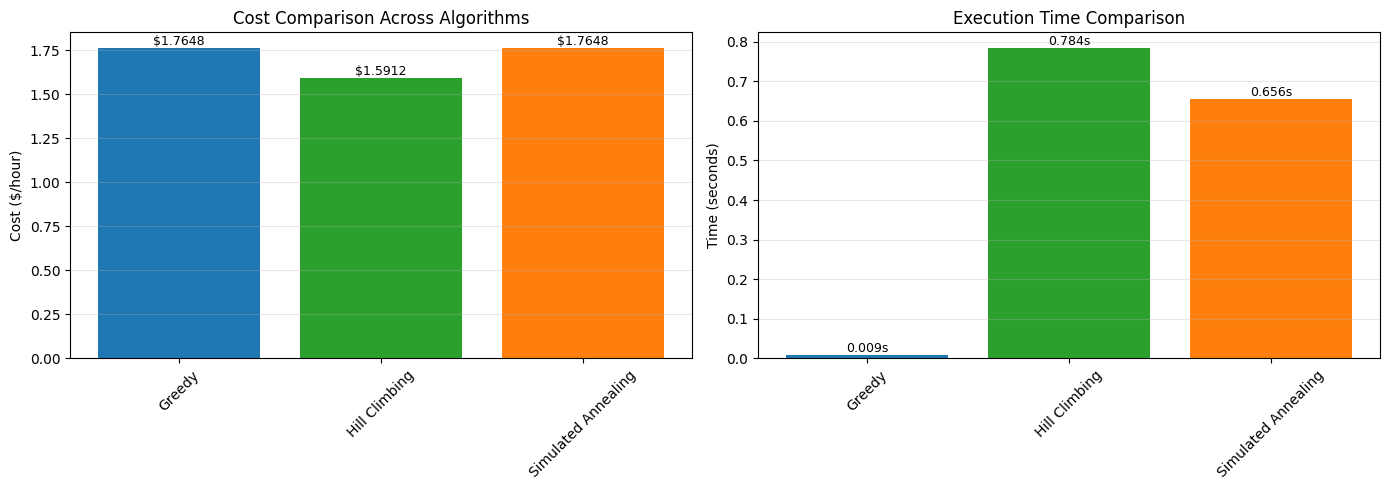

In [85]:
# Visualization: Cost comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Cost comparison
algorithms = list(results.keys())
costs = [results[algo]['cost'] for algo in algorithms]
times = [results[algo]['time'] for algo in algorithms]

axes[0].bar(algorithms, costs, color=['#1f77b4', '#2ca02c', '#ff7f0e'])
axes[0].set_ylabel('Cost ($/hour)')
axes[0].set_title('Cost Comparison Across Algorithms')
axes[0].tick_params(axis='x', rotation=45)
axes[0].grid(axis='y', alpha=0.3)

# Add value labels on bars
for i, (algo, cost) in enumerate(zip(algorithms, costs)):
    axes[0].text(i, cost, f'${cost:.4f}', ha='center', va='bottom', fontsize=9)

# Execution time comparison
axes[1].bar(algorithms, times, color=['#1f77b4', '#2ca02c', '#ff7f0e'])
axes[1].set_ylabel('Time (seconds)')
axes[1].set_title('Execution Time Comparison')
axes[1].tick_params(axis='x', rotation=45)
axes[1].grid(axis='y', alpha=0.3)

# Add value labels on bars
for i, (algo, t) in enumerate(zip(algorithms, times)):
    axes[1].text(i, t, f'{t:.3f}s', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()


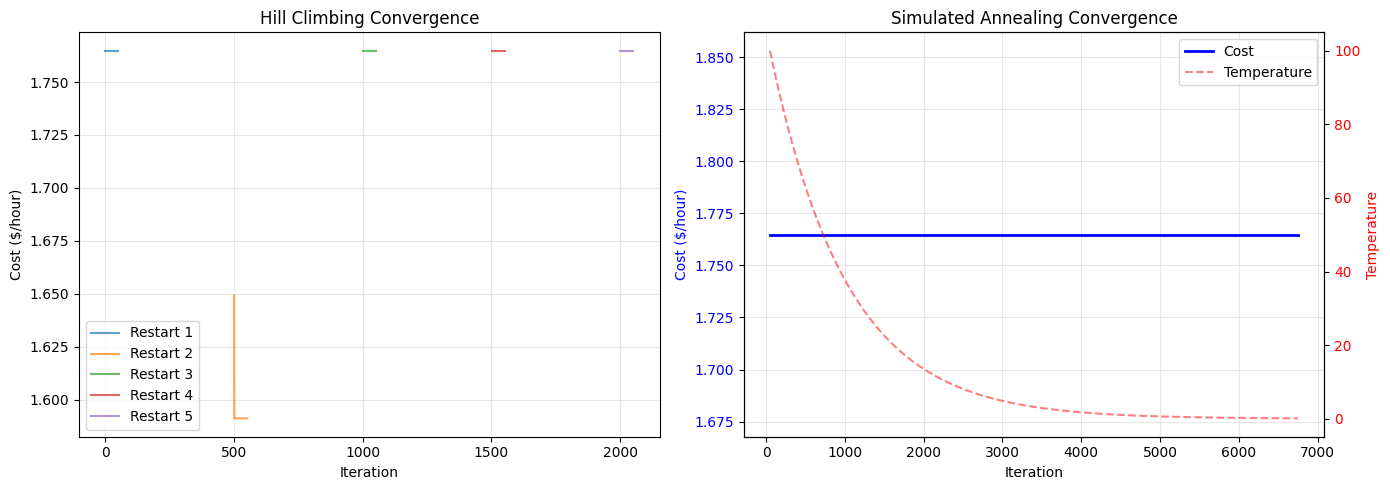

In [86]:
# Visualization: Convergence plots for Hill Climbing and Simulated Annealing
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Hill Climbing convergence
if 'history' in hc_result:
    hc_history = hc_result['history']
    hc_iterations = [h['iteration'] for h in hc_history]
    hc_costs = [h['cost'] for h in hc_history]
    
    # Color by restart
    if hc_history and 'restart' in hc_history[0]:
        for restart_num in range(1, 6):
            restart_data = [h for h in hc_history if h.get('restart') == restart_num]
            if restart_data:
                iterations = [h['iteration'] for h in restart_data]
                costs = [h['cost'] for h in restart_data]
                axes[0].plot(iterations, costs, '-', linewidth=1.5, alpha=0.7, 
                       label=f'Restart {restart_num}')
    else:
        axes[0].plot(hc_iterations, hc_costs, 'g-', linewidth=2, label='Best Cost')
    
    axes[0].set_xlabel('Iteration')
    axes[0].set_ylabel('Cost ($/hour)')
    axes[0].set_title('Hill Climbing Convergence')
    axes[0].grid(alpha=0.3)
    axes[0].legend()

# Simulated Annealing convergence
if 'history' in sa_result:
    sa_history = sa_result['history']
    sa_iterations = [h['iteration'] for h in sa_history]
    sa_costs = [h['cost'] for h in sa_history]
    sa_temps = [h['temp'] for h in sa_history]
    
    ax1 = axes[1]
    ax1_twin = ax1.twinx()
    
    line1 = ax1.plot(sa_iterations, sa_costs, 'b-', label='Cost', linewidth=2)
    line2 = ax1_twin.plot(sa_iterations, sa_temps, 'r--', label='Temperature', alpha=0.5)
    
    ax1.set_xlabel('Iteration')
    ax1.set_ylabel('Cost ($/hour)', color='b')
    ax1_twin.set_ylabel('Temperature', color='r')
    ax1.set_title('Simulated Annealing Convergence')
    ax1.grid(alpha=0.3)
    ax1.tick_params(axis='y', labelcolor='b')
    ax1_twin.tick_params(axis='y', labelcolor='r')
    
    lines = line1 + line2
    labels = [l.get_label() for l in lines]
    ax1.legend(lines, labels, loc='upper right')

plt.tight_layout()
plt.show()



Let's examine the best solution in detail:

In [87]:
# Detailed breakdown of best solution
best_result = results[best_algo]

print(f"Detailed Analysis of Best Solution ({best_algo})")
print("=" * 80)

# Calculate total resources
total_replicas = sum(best_result['r'].values())
total_cpu_available = np.sum(best_result['x'] * df_vm_clean['CPU'].values)
total_ram_available = np.sum(best_result['x'] * df_vm_clean['RAM'].values)
total_capacity_available = np.sum(best_result['x'] * df_vm_clean['max_replicas'].values)

print(f"\nTotal Replicas Required: {total_replicas}")
print(f"  Component 1: {best_result['r'][1]} (min: {r_min[1]})")
print(f"  Component 2: {best_result['r'][2]} (min: {r_min[2]})")
print(f"  Component 3: {best_result['r'][3]} (min: {r_min[3]})")
print(f"  Component 4: {best_result['r'][4]} (min: {r_min[4]})")

print(f"\nTotal Resources Available:")
print(f"  CPU: {total_cpu_available} cores")
print(f"  RAM: {total_ram_available:.2f} GiB")
print(f"  Replica Capacity: {total_capacity_available} replicas")

print(f"\nResource Requirements:")
print(f"  CPU: {total_replicas} cores (utilization: {total_replicas/total_cpu_available*100:.2f}%)")
print(f"  RAM: {0.25*total_replicas:.2f} GiB (utilization: {0.25*total_replicas/total_ram_available*100:.2f}%)")
print(f"  Capacity: {total_replicas} replicas (utilization: {total_replicas/total_capacity_available*100:.2f}%)")

print(f"\nVM Allocation Breakdown:")
vm_allocation_df = pd.DataFrame({
    'VM Type': df_vm_clean['Type'].values,
    'Quantity': best_result['x'],
    'Cost per VM': df_vm_clean['Cost'].values,
    'Total Cost': best_result['x'] * df_vm_clean['Cost'].values,
    'CPU per VM': df_vm_clean['CPU'].values,
    'RAM per VM': df_vm_clean['RAM'].values,
    'Max Replicas': df_vm_clean['max_replicas'].values
})
vm_allocation_df = vm_allocation_df[vm_allocation_df['Quantity'] > 0]
vm_allocation_df = vm_allocation_df.sort_values('Total Cost', ascending=False)
print(vm_allocation_df.to_string(index=False))

print(f"\nTotal Hourly Cost: ${best_result['cost']:.4f}")
print(f"Daily Cost (24h): ${best_result['cost'] * 24:.2f}")
print(f"Monthly Cost (30 days): ${best_result['cost'] * 24 * 30:.2f}")


Detailed Analysis of Best Solution (Hill Climbing)

Total Replicas Required: 25
  Component 1: 5 (min: 5)
  Component 2: 9 (min: 9)
  Component 3: 6 (min: 6)
  Component 4: 5 (min: 5)

Total Resources Available:
  CPU: 26 cores
  RAM: 23.40 GiB
  Replica Capacity: 26 replicas

Resource Requirements:
  CPU: 25 cores (utilization: 96.15%)
  RAM: 6.25 GiB (utilization: 26.71%)
  Capacity: 25 replicas (utilization: 96.15%)

VM Allocation Breakdown:
VM Type  Quantity  Cost per VM  Total Cost  CPU per VM  RAM per VM  Max Replicas
    T10         1       0.8824      0.8824          16        14.4            16
    T07         1       0.4984      0.4984           8         7.2             8
    T01         1       0.2104      0.2104           2         1.8             2

Total Hourly Cost: $1.5912
Daily Cost (24h): $38.19
Monthly Cost (30 days): $1145.66
